In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from arch import arch_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from warnings import filterwarnings
filterwarnings('ignore')
%matplotlib inline

In [52]:
data = pd.read_csv('data/ghana_gdp.zip', parse_dates=['year'], index_col=['year'])
display(data.head())
display(data.tail())

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


,GDP (current US$)
year,
2017-01-01,6.040638e+10
2018-01-01,6.729928e+10
2019-01-01,6.833754e+10
2020-01-01,7.004320e+10
2021-01-01,7.759428e+10


<AxesSubplot: title={'center': 'Данные по ВВП Ганны'}, xlabel='Годы', ylabel='Значение ВВП'>

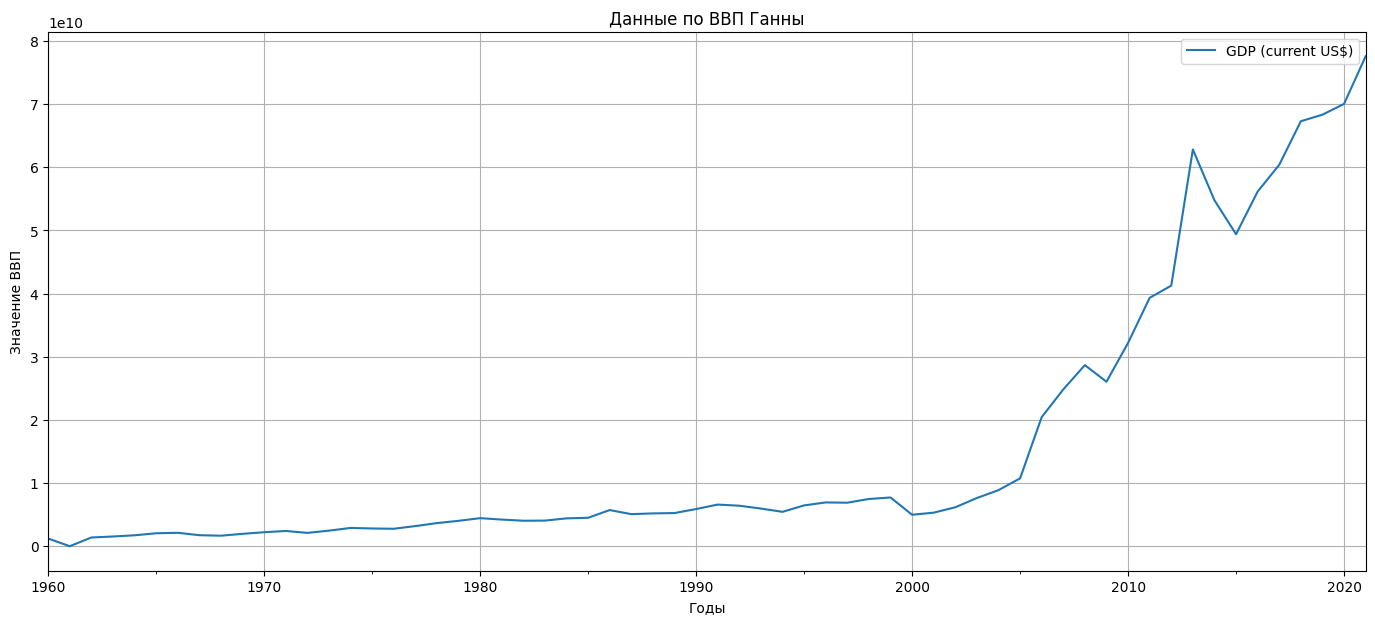

In [53]:
data['GDP (current US$)'].plot(
    kind='line',
    figsize=(17, 7),
    legend=True,
    title='Данные по ВВП Ганны',
    grid=True,
    xlabel='Годы',
    ylabel='Значение ВВП'
)

На графике видно, что тренд возрастающий на всем продяжении, но начиная с 2000 года рост стремительно увеличился.

In [54]:
data_train = data[:'2018-01-01']
data_test = data['2019-01-01':]

print(data_train.shape, data_test.shape)

(59, 1) (3, 1)


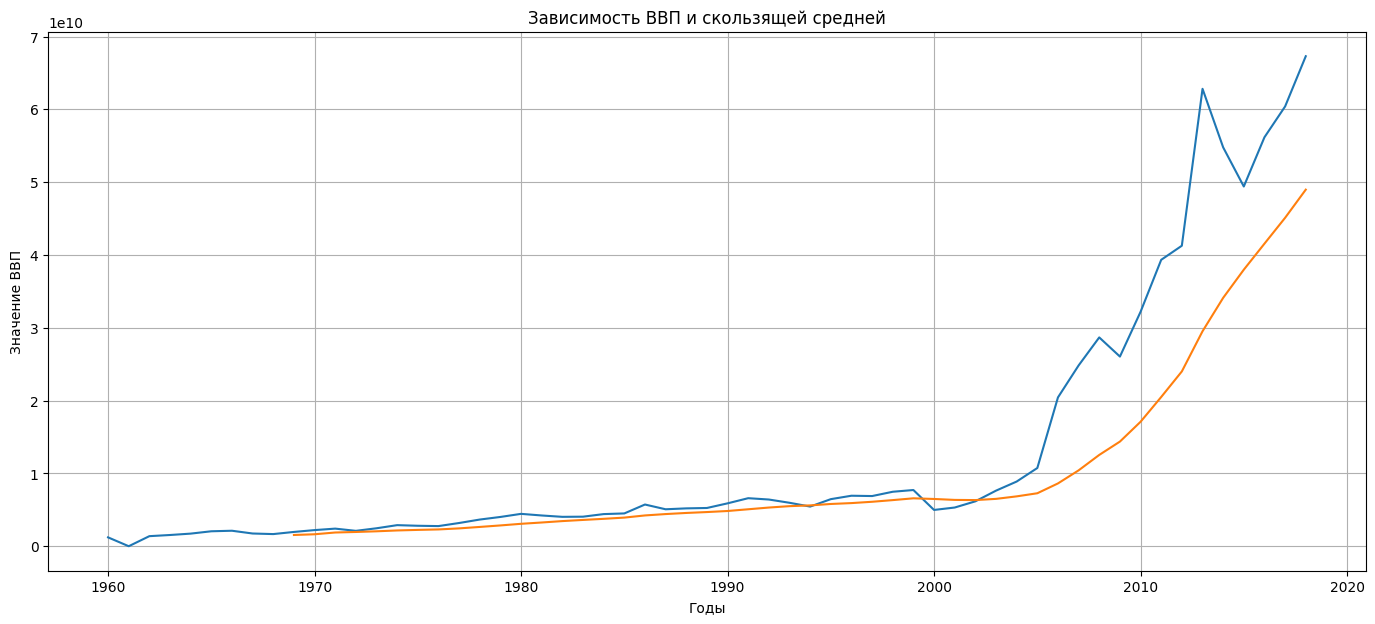

In [55]:
fig, ax = plt.subplots(figsize=(17, 7))
ax.plot(data_train)
ax.plot(data_train.rolling(window=10).mean())
ax.set_title('Зависимость ВВП и скользящей средней')
ax.set_xlabel('Годы')
ax.set_ylabel('Значение ВВП')
ax.grid()

На графике видно, что если значение ВВП находится выше скользящей средней и наклон ее вверх, то график растет.

## Декомпозиция

In [56]:
decomposition = seasonal_decompose(data_train)

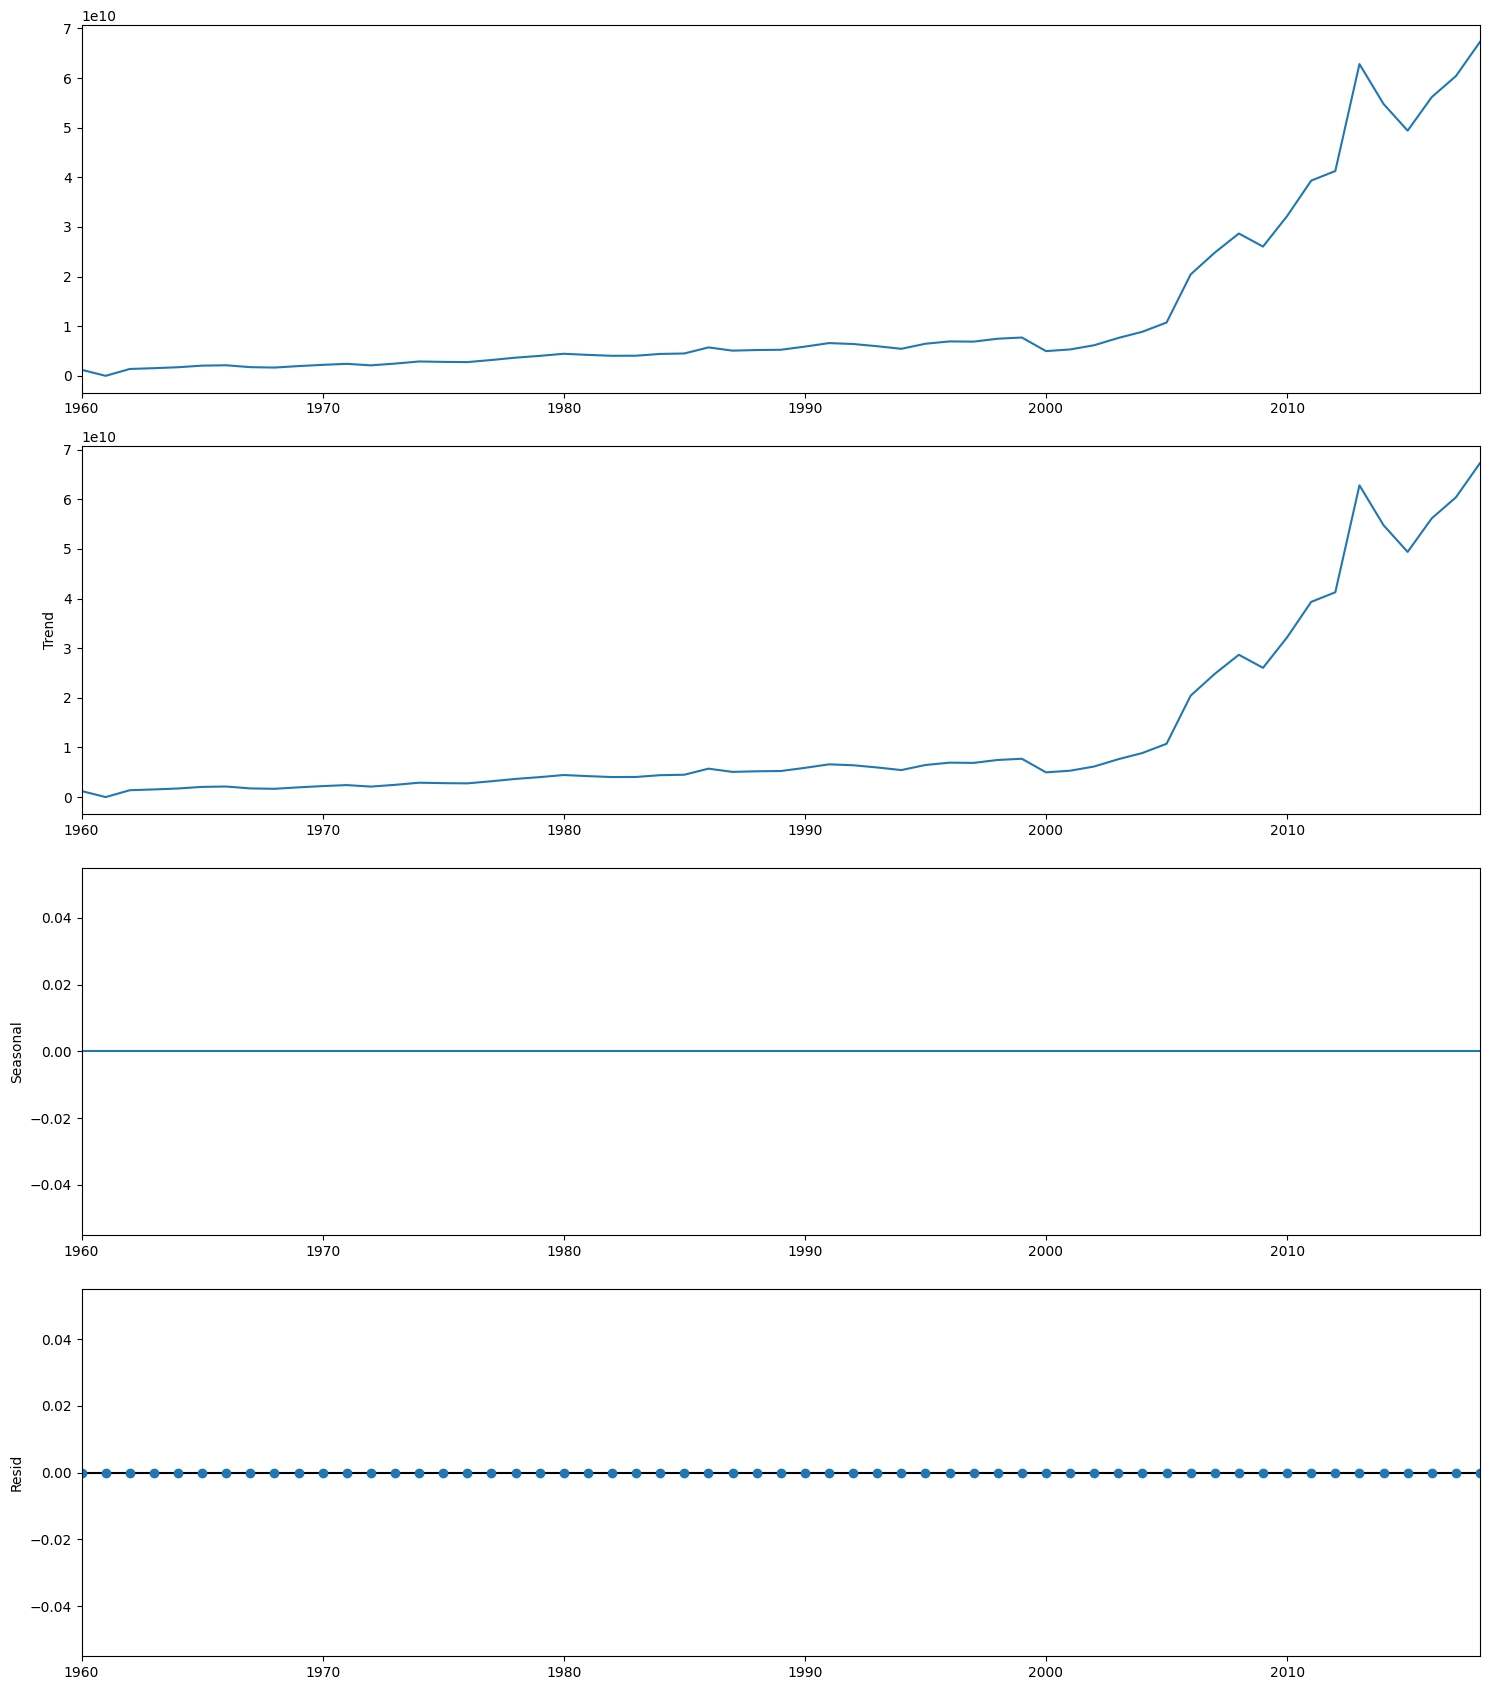

In [57]:
plt.rcParams['figure.figsize'] = 15, 17
decomposition.plot()
plt.show()

Исходя из графиков, можно сказать, что есть только восходящий тренд.

Так как нам надо сделать долгосрочный прогноз, то будем проверять ряд на стационарность.

## Стационарность временного ряда

In [58]:
def stat_test(df):

    test = adfuller(df)

    print ('adf: ', test[0] )
    print ('p-value: ', test[1])
    print('Critical values: ', test[4])

    if test[0] > test[4]['5%']:
        print ('Есть единичные корни, ряд не стационарен.')

    else:
        print ('Единичных корней нет, ряд стационарен.')

stat_test(data_train)

adf:  0.6529066974885349
p-value:  0.9888496277665572
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
Есть единичные корни, ряд не стационарен.


Так как ряд не стационарен, то проведем дифференцирование.

In [59]:
data_train_diff_1 = data_train.diff().dropna()

stat_test(data_train_diff_1)

adf:  -1.6702483038320777
p-value:  0.446502932971389
Critical values:  {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616}
Есть единичные корни, ряд не стационарен.


In [60]:
data_train_diff_2 = data_train_diff_1.diff().dropna()

stat_test(data_train_diff_2)

adf:  -2.6408690561284898
p-value:  0.08484116917837664
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
Есть единичные корни, ряд не стационарен.


In [61]:
data_train_diff_3 = data_train_diff_2.diff().dropna()

stat_test(data_train_diff_3)

adf:  -4.779623784828512
p-value:  5.9483276402254376e-05
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
Единичных корней нет, ряд стационарен.


Параметр $d=3$.

## Коррелограммы ACF и PACF

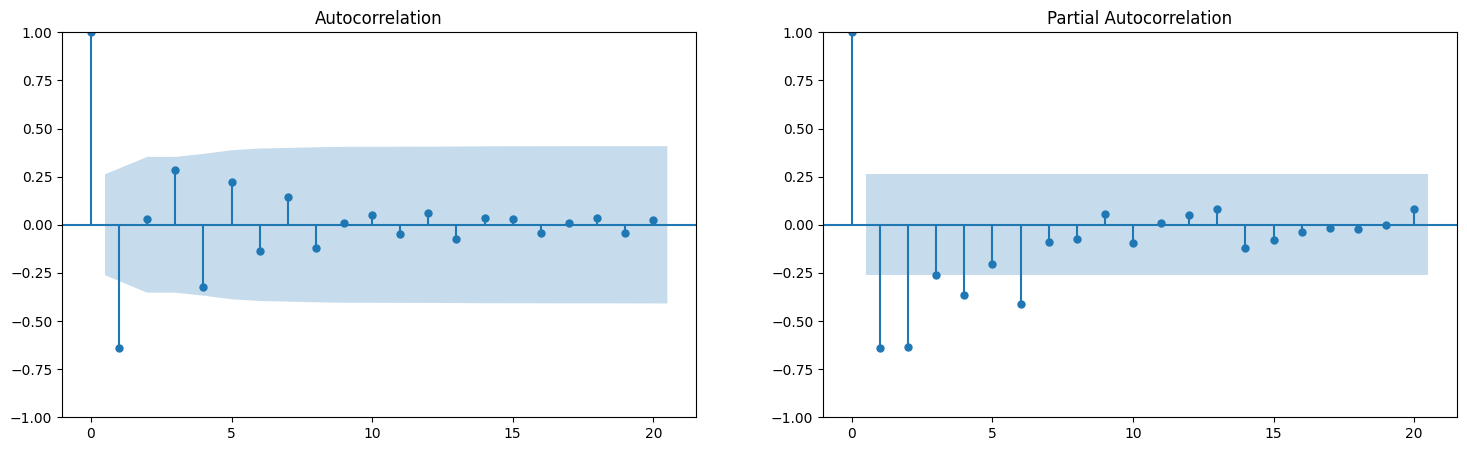

In [62]:
def plot_acf_pacf(series):

    plt.rcParams['figure.figsize'] = 18, 5

    fig, axes = plt.subplots(1, 2)

    sgt.plot_acf(series, ax=axes[0], lags=20)
    sgt.plot_pacf(series, ax=axes[1], lags=20, method='ywm')
    plt.show()


plot_acf_pacf(data_train_diff_3)

Из графика частичной автокорреляции берем значение $p=2$ и $q=1$.

## ARIMA / SARIMAX

In [63]:
arima_model = ARIMA(data_train, order=(2, 3, 1))
arima_model_fit = arima_model.fit()
print(arima_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(2, 3, 1)   Log Likelihood               -1325.615
Date:                Mon, 25 Sep 2023   AIC                           2659.231
Time:                        10:54:08   BIC                           2667.332
Sample:                    01-01-1960   HQIC                          2662.372
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7427      0.129     -5.765      0.000      -0.995      -0.490
ar.L2         -0.4577      0.223     -2.055      0.040      -0.894      -0.021
ma.L1         -0.9730      0.110     -8.808      0.0

In [64]:
sarimax_model = SARIMAX(data_train, order=(2, 3, 1))
sarimax_model_fit = sarimax_model.fit()
print(sarimax_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:               SARIMAX(2, 3, 1)   Log Likelihood               -1325.615
Date:                Mon, 25 Sep 2023   AIC                           2659.231
Time:                        10:54:21   BIC                           2667.332
Sample:                    01-01-1960   HQIC                          2662.372
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7427      0.129     -5.765      0.000      -0.995      -0.490
ar.L2         -0.4577      0.223     -2.055      0.040      -0.894      -0.021
ma.L1         -0.9730      0.110     -8.808      0.0

## PAMDARIMA

Подбор параметров

In [65]:
pamdarima_model = pm.auto_arima(
    data_train,
    start_p=1,
    d=3,
    start_q=1,
    max_p=3,
    max_q=3,
    max_d=3,
    D=3,
    start_P=0,
    # m=1,
    test='adf',
    error_action='ignore',
    trace=True,
)

# Выводим результат.
print(pamdarima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,3,1)(0,0,0)[0]             : AIC=2670.910, Time=0.08 sec
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=2734.956, Time=0.12 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=2707.192, Time=0.03 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=2682.371, Time=0.06 sec
 ARIMA(2,3,1)(0,0,0)[0]             : AIC=2659.231, Time=0.09 sec
 ARIMA(2,3,0)(0,0,0)[0]             : AIC=2679.050, Time=0.04 sec
 ARIMA(3,3,1)(0,0,0)[0]             : AIC=2660.791, Time=0.14 sec
 ARIMA(2,3,2)(0,0,0)[0]             : AIC=inf, Time=0.44 sec
 ARIMA(1,3,2)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(3,3,0)(0,0,0)[0]             : AIC=2676.883, Time=0.06 sec
 ARIMA(3,3,2)(0,0,0)[0]             : AIC=inf, Time=0.46 sec
 ARIMA(2,3,1)(0,0,0)[0] intercept   : AIC=2666.241, Time=0.12 sec

Best model:  ARIMA(2,3,1)(0,0,0)[0]          
Total fit time: 1.923 seconds
                               SARIMAX Results                                
Dep. Variable:          

Так как значения, подобранные PAMDARIMA приводят модель к таким же показателям $AIC$, $BIC$ и $HQIC$, то оставим параметры (p=2, d=3, q=1) и предсказание будем осуществлять на них.

## Предсказание модели

## Downsampling / Upsampling / Интерполяция

In [66]:
df = data.asfreq(freq='AS')

df['GDP (current US$)'] = df['GDP (current US$)'].apply(lambda x: np.nan if x==0 else x)

print('Количество пропущенных значений -', df.isnull().sum())

Количество пропущенных значений - GDP (current US$)    1
dtype: int64


In [67]:
df = df['GDP (current US$)'].interpolate(method='linear')
print('Количество пропущенных значений -', df.isnull().sum())

Количество пропущенных значений - 0


In [68]:
df = pd.DataFrame(df)

In [69]:
df_train = df[:'2018-01-01']
df_test = df['2019-01-01':]

## Стационарность временного ряда

In [70]:
def stat_test(df):

    test = adfuller(df)

    print ('adf: ', test[0] )
    print ('p-value: ', test[1])
    print('Critical values: ', test[4])

    if test[0] > test[4]['5%']:
        print ('Есть единичные корни, ряд не стационарен.')

    else:
        print ('Единичных корней нет, ряд стационарен.')

stat_test(df)

adf:  2.380848757555631
p-value:  0.99900101016983
Critical values:  {'1%': -3.542412746661615, '5%': -2.910236235808284, '10%': -2.5927445767266866}
Есть единичные корни, ряд не стационарен.


In [71]:
df_diff_1 = df_train.diff().dropna()
stat_test(df_diff_1)

adf:  -1.8255652246435998
p-value:  0.36784515276563423
Critical values:  {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616}
Есть единичные корни, ряд не стационарен.


In [72]:
df_diff_2 = df_diff_1.diff().dropna()
stat_test(df_diff_2)

adf:  -2.634634746007842
p-value:  0.0860481372219768
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
Есть единичные корни, ряд не стационарен.


In [73]:
df_diff_3 = df_diff_2.diff().dropna()
stat_test(df_diff_3)

adf:  -4.825603687304014
p-value:  4.857318076800112e-05
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
Единичных корней нет, ряд стационарен.


Параметр $d=3$.

## Коррелограммы ACF и PACF

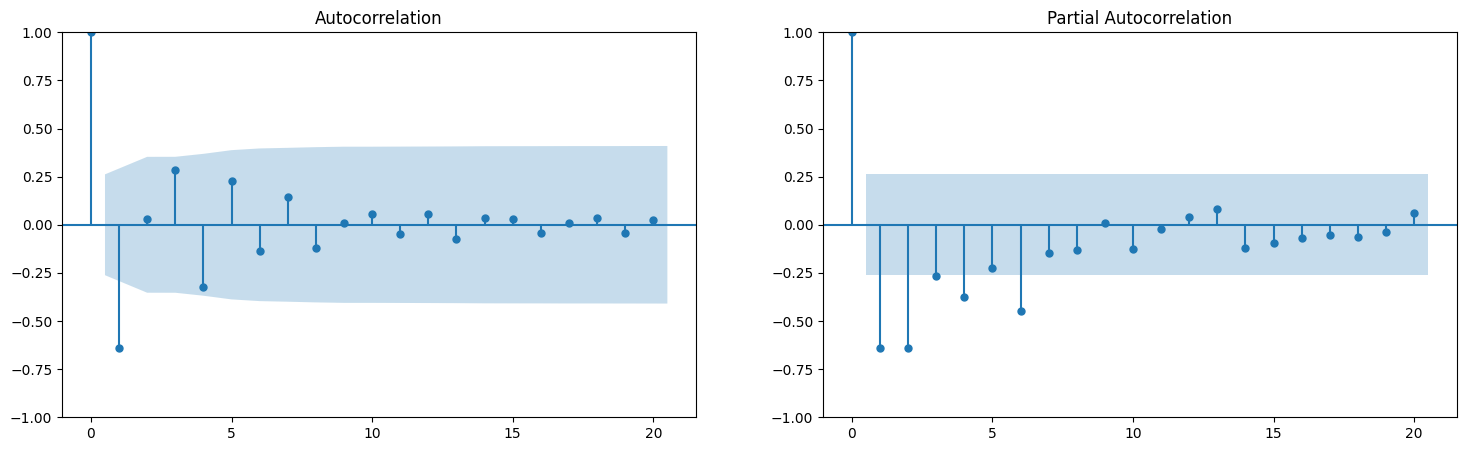

In [74]:
plot_acf_pacf(df_diff_3)

Из графика частичной автокорреляции берем значение $p=2$ и $q=1$.

## ARIMA / SARIMAX

In [75]:
arima_model = ARIMA(df_train, order=(2, 3, 1))
arima_model_fit = arima_model.fit()
print(arima_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(2, 3, 1)   Log Likelihood               -1325.613
Date:                Mon, 25 Sep 2023   AIC                           2659.226
Time:                        10:58:16   BIC                           2667.328
Sample:                    01-01-1960   HQIC                          2662.367
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7420      0.129     -5.756      0.000      -0.995      -0.489
ar.L2         -0.4585      0.223     -2.056      0.040      -0.895      -0.022
ma.L1         -0.9729      0.110     -8.806      0.0

In [76]:
sarimax_model = SARIMAX(df_train, order=(2, 3, 1))
sarimax_model_fit = sarimax_model.fit()
print(sarimax_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:               SARIMAX(2, 3, 1)   Log Likelihood               -1325.613
Date:                Mon, 25 Sep 2023   AIC                           2659.226
Time:                        10:58:29   BIC                           2667.328
Sample:                    01-01-1960   HQIC                          2662.367
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7420      0.129     -5.756      0.000      -0.995      -0.489
ar.L2         -0.4585      0.223     -2.056      0.040      -0.895      -0.022
ma.L1         -0.9729      0.110     -8.806      0.0

 После интерполяции временного ряда значения $AIC$, $BIC$ и $HQIC$ не изменились.

## Предсказание модели

In [77]:
pred_arima_model = pd.DataFrame(index=df.index)

pred_arima_model['model_prediction'] = arima_model_fit.predict(
    start=df_test.index[0],
    end=df_test.index[-1]
)
pred_arima_model['GDP (current US$)'] = df['GDP (current US$)']

forecast = arima_model_fit.get_forecast(len(df_test.index))
forecast_df = forecast.conf_int(alpha=0.05)

pred_arima_model.at[data_test.index, 'model_preds_lower'] = forecast_df['lower GDP (current US$)']
pred_arima_model.at[data_test.index, 'model_preds_upper'] = forecast_df['upper GDP (current US$)']

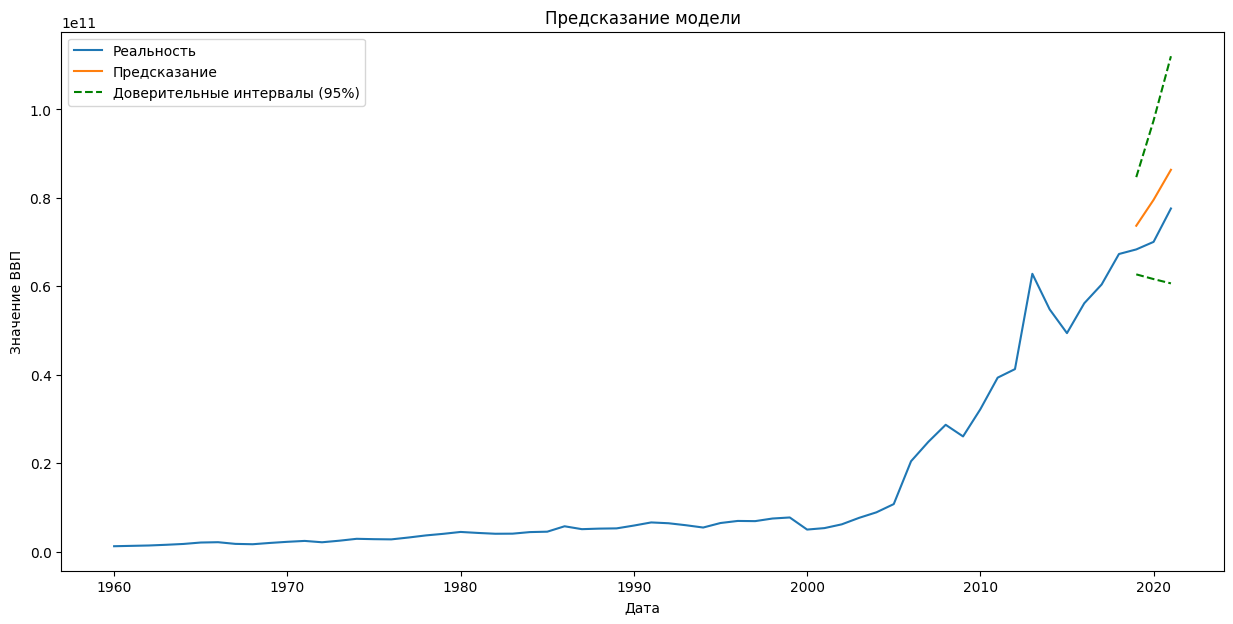

In [78]:
fig = plt.figure(figsize=(15, 7))

fig = plt.plot(
    pred_arima_model['GDP (current US$)'],
    label='Реальность'
)

fig = plt.plot(
    pred_arima_model['model_prediction'],
    label='Предсказание'
)

fig = plt.plot(
    pred_arima_model.loc[df_test.index]['model_preds_lower'],
    color='green',
    linestyle='--',
    label='Доверительные интервалы (95%)'
)

fig = plt.plot(
    pred_arima_model.loc[df_test.index]['model_preds_upper'],
    color='green',
    linestyle='--'
)

plt.title('Предсказание модели')
plt.legend()
plt.xlabel('Дата')
plt.ylabel('Значение ВВП')

Text(0, 0.5, 'Значение ВВП')

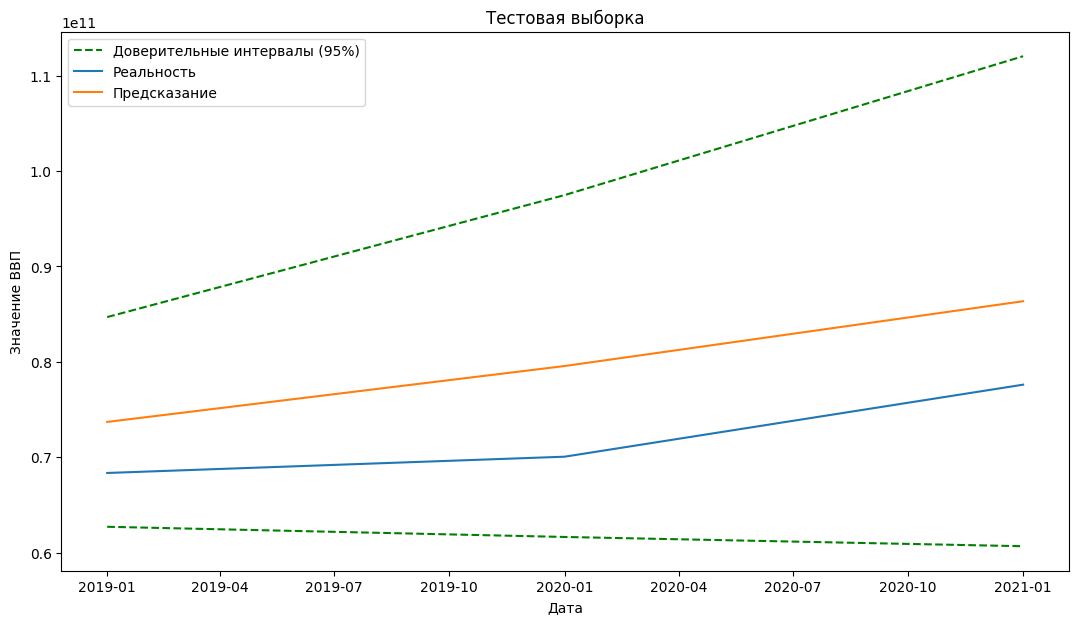

In [79]:
fig = plt.figure(figsize=(13, 7))

fig = plt.plot(
    pred_arima_model.loc[data_test.index]['model_preds_lower'],
    color='green',
    linestyle='--',
    label='Доверительные интервалы (95%)'
)

fig = plt.plot(
    pred_arima_model.loc[data_test.index]['model_preds_upper'],
    color='green',
    linestyle='--'
)

fig = plt.plot(
    pred_arima_model.loc[data_test.index]['GDP (current US$)'],
    label='Реальность'
)

fig = plt.plot(
    pred_arima_model.loc[data_test.index]['model_prediction'],
    label='Предсказание'
)

plt.title('Тестовая выборка')
plt.legend()
plt.xlabel('Дата')
plt.ylabel('Значение ВВП')

Изменений нет

## Волатильность

 **Volatility** at time **t**

$Vol(t) = |\frac{Price(t) - Price(t-1)}{Price(t-1)} * 100|$

In [80]:
df['volatility'] = df['GDP (current US$)'].pct_change(1).mul(100).abs()
df['volatility'].head()

year
1960-01-01          NaN
1961-01-01     6.789413
1962-01-01     6.357759
1963-01-01    11.448835
1964-01-01    12.363636
Freq: AS-JAN, Name: volatility, dtype: float64

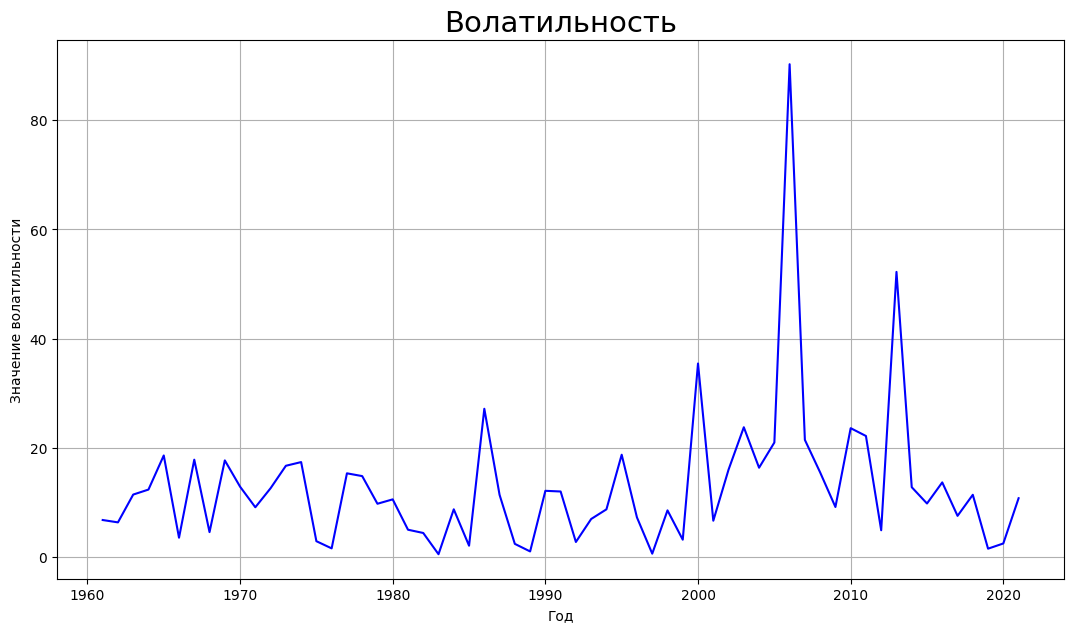

In [81]:
fig = plt.figure(figsize=(13, 7))

plt.plot(df['volatility'], c='blue')
plt.title('Волатильность', size=21)
plt.xlabel('Год')
plt.ylabel('Значение волатильности')
plt.grid()

In [82]:
df_train = df[:'2010-01-01']
df_test = df['2011-01-01':]

## Стационарность временного ряда

In [83]:
stat_test(df_train.volatility[1:])

adf:  -5.832296782652174
p-value:  3.94922865344542e-07
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
Единичных корней нет, ряд стационарен.


## Коррелограммы ACF и PACF

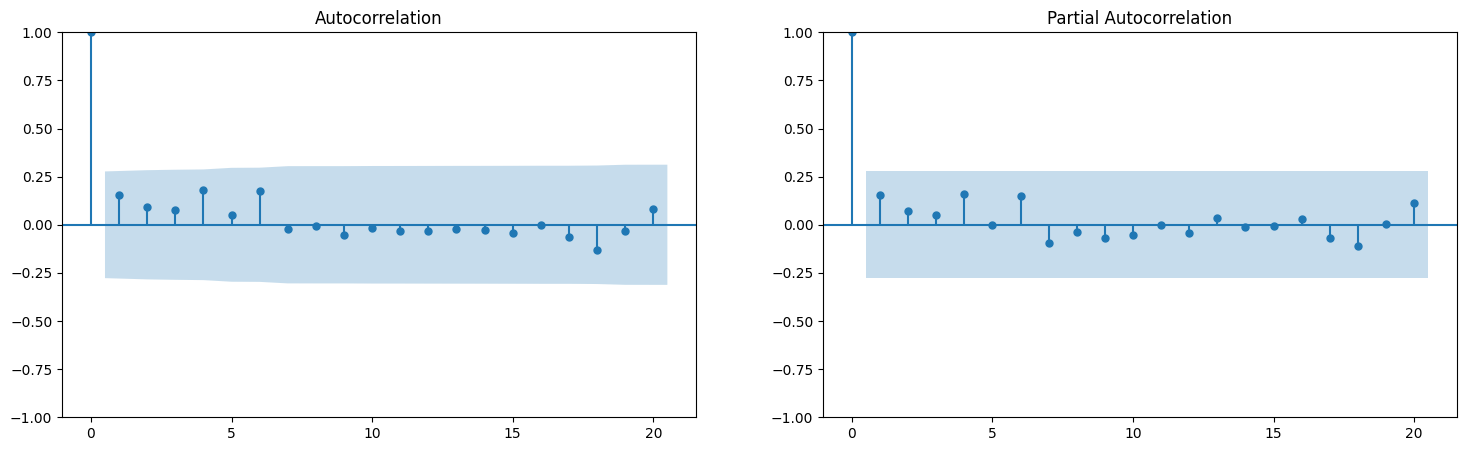

In [84]:
plot_acf_pacf(df_train.volatility[1:])

Из графика частичной автокорреляции берем значение $p=1$ и $q=1$.

## ARCH

Берем за исходные данные весь датасет с индексами, который содержит и train и test часть

In [86]:
garch_df = pd.DataFrame(df['volatility'])

In [88]:
model = arch_model(garch_df['volatility'].dropna(), p=1, q=1)
model_results = model.fit(last_obs=df_test.index[0], update_freq=5)
print(model_results.summary())

Iteration:      5,   Func. Count:     27,   Neg. LLF: 193.66096978324273
Iteration:     10,   Func. Count:     53,   Neg. LLF: 193.0918965848066
Optimization terminated successfully    (Exit mode 0)
            Current function value: 193.0918965848066
            Iterations: 11
            Function evaluations: 57
            Gradient evaluations: 11
                     Constant Mean - GARCH Model Results                      
Dep. Variable:             volatility   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -193.092
Distribution:                  Normal   AIC:                           394.184
Method:            Maximum Likelihood   BIC:                           401.832
                                        No. Observations:                   50
Date:                Mon, Sep 25 2023   Df Residuals:                       49
Time:         

## Предсказание модели

In [89]:
pred_df = df_test.copy()
pred_df['predictions'] = model_results.forecast().residual_variance.loc[df_test.index]

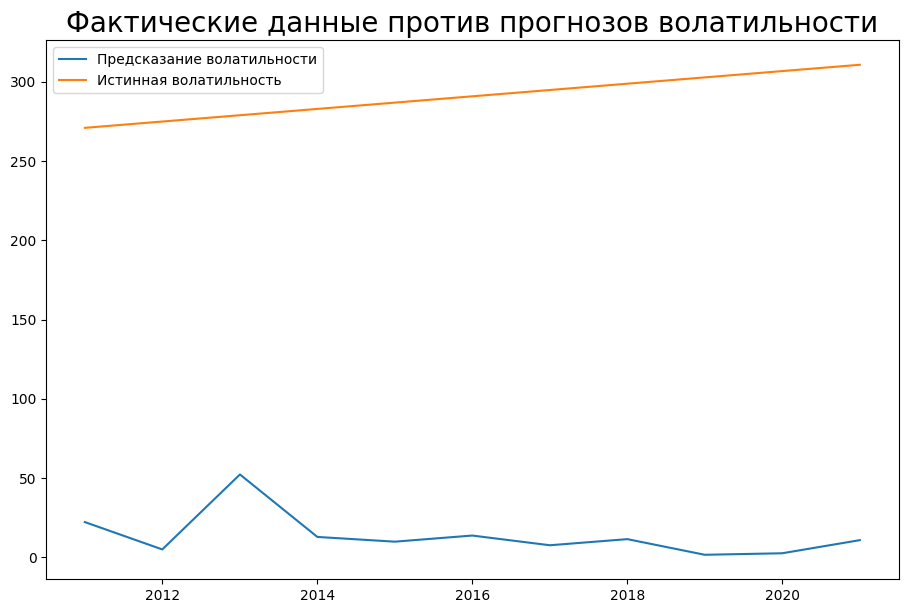

In [90]:
fig = plt.figure(figsize=(11, 7))

plt.plot(
    pred_df['volatility'],
    label='Предсказание волатильности'
)

plt.plot(
    pred_df['predictions'],
    label='Истинная волатильность'
)

plt.title('Фактические данные против прогнозов волатильности', size=20)
plt.legend()

In [91]:
print('Показание метрики - {:.3f}'.format(mean_squared_error(pred_df['volatility'], pred_df['predictions'])))

Показание метрики - 77375.146


Судя по полученному графику и метрике, модель не уловила дисперсию, так как такое поведение было для неё новым и подобные случаи отсутствовали в обучающей выборке. Необходимо больше данных, которые показывают разные ситуации.

## LinearRegression

In [92]:
X_train = pd.DataFrame(range(df['volatility'].shape[0]))[
    : df_train.shape[0]
].fillna(0)
X_test = pd.DataFrame(range(df['volatility'].shape[0]))[
    df_train.shape[0] :
].fillna(0)
y_train = df_train['volatility'].fillna(0)
y_test =df_test['volatility'].fillna(0)

In [93]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)

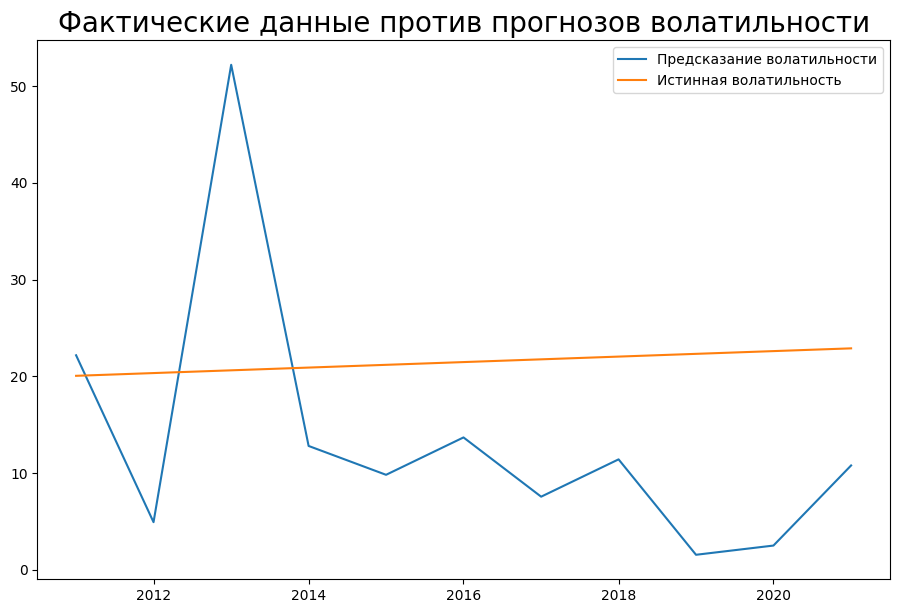

In [94]:
fig = plt.figure(figsize=(11, 7))

plt.plot(
    y_test,
    label='Предсказание волатильности'
)

plt.plot(
    pd.Series(lr_predict, index=y_test.index),
    label='Истинная волатильность'
)

plt.title('Фактические данные против прогнозов волатильности', size=20)
plt.legend()

Линейная регрессия оказалась ближе к реальным значения волатильности, но все равно колебания не улавливаются.